In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import tensorflow as tf

import librosa
import librosa.display
import os

from tensorflow import keras
from tensorflow.keras import layers, models
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.utils import to_categorical

### Cargar los datos

Para caargar los datos tendremos que:

* Recorrer cada audio de cada carpeta
* Guardar el nombre de cada carpeta, representa el numero que se esta diciendo en el audio
* Leer el audio y obtener sus parametros
*Transformar la onda a monocanal
* Adaptar el sample rate de cada audio para poner todos iguales
* Ponerle un tamaña igual a todos los audios
* Añadir ruido y desplazamientos
* Pasar la frecuencia a escala de mel
* Realizar el espectograma
* Guardar la imagen generada


In [3]:
def get_spectogram(path):
    imagenes = []
    values = []
    for name in os.listdir(path):
        # if name.endswith(".wav"):
        ruta = os.path.join(path, name)
        samples, sample_rate = librosa.load(ruta, sr=None, mono=False)
        samples_mono = librosa.to_mono(samples)
        values.append(name.split("_")[0])
        # Bajar, adaptar el sample rate para voz
        sr = 22050
        sample_resamp = librosa.resample(samples_mono,orig_sr=sample_rate,target_sr=sr)

        # tamaño a 2 segundos
        max_ms = 2000
        sig_len = sample_resamp.shape[0]
        max_len=(sr * max_ms)//1000
        if sig_len >= max_len: #Truncar
            samples_trunc = sample_resamp[:max_len]
        else: # expandir con zeros
            z = np.zeros(max_len -sig_len, dtype=sample_resamp.dtype)
            samples_trunc = np.concatenate((sample_resamp,z),axis=0)
        
        shift_limit = 0.1 # % a desplazar
        sig_len = samples_trunc.shape[0]
        shift_len = int(shift_limit * sig_len) 
        samples_shift = np.roll(samples_trunc,shift_len)

        # meter ruido. Ajustamos la relacion Señal / ruido
        SNR = 50
        RMS_s = math.sqrt(np.mean(samples_shift**2))
        RMS_n = math.sqrt(np.mean(RMS_s**2/pow(10,SNR/10)))
        noise = np.random.normal(0,RMS_n,samples_shift.shape[0])
        samples_noise = samples_shift + noise

        # pasar a spectograma y guardarlo
        fig = plt.Figure()
        sgram = librosa.stft(samples_noise, n_fft=1024, hop_length=None)
        sgram = librosa.feature.melspectrogram(S=sgram, sr=sr, n_mels=64)
        sgram = librosa.amplitude_to_db(S=sgram, ref=np.min)
        imagenes.append(sgram)

    return imagenes, values

In [5]:
from joblib import Parallel, delayed

import pathlib
path=str(pathlib.Path().resolve())+"/data/"

archivos_a_procesar = []
for dir in os.listdir(path):
    archivos_a_procesar.append(path+dir)

resultados = Parallel(n_jobs=-1)(delayed(get_spectogram)(f) for f in archivos_a_procesar)

imagenes = [resultado[0] for resultado in resultados]
values = [resultado[1] for resultado in resultados]


In [23]:
# Pasar a array de numpy

imagenes = np.array(imagenes)
values = np.array(values,dtype=np.int64)

In [22]:
print("Espectograma shape:",imagenes.shape)
print("Values shape:", values.shape)

Espectograma shape: (60, 500, 64, 173)
Values shape: (60, 500)


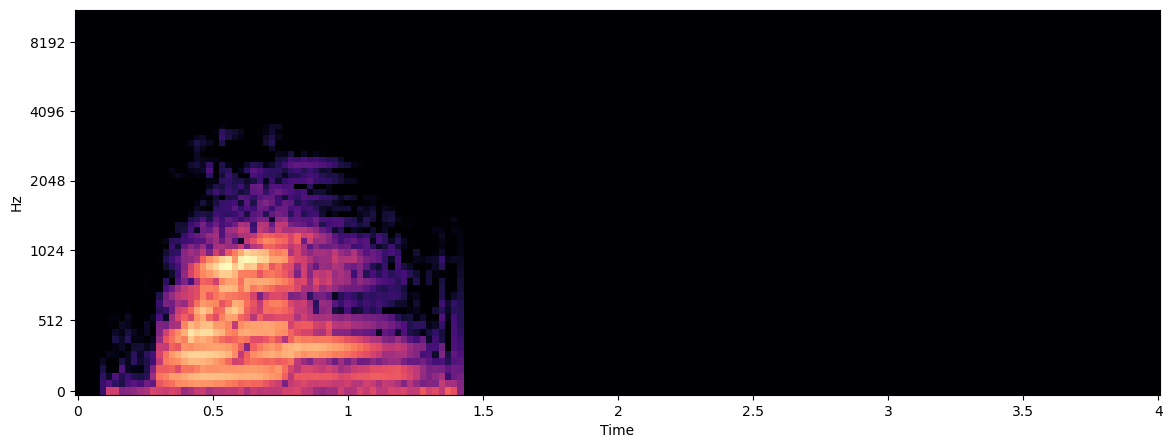

In [107]:
plt.figure(figsize=(14,5))
librosa.display.specshow(imagenes[50][65], sr=22050, x_axis="time", y_axis="mel")

In [24]:
y = []
for i in values:
    for j in i:
        y.append(j)
y = np.array(y)

In [25]:
y.shape

(30000,)

In [26]:
x = []
for i in imagenes:
    for j in i:
        x.append(j)
x = np.array(x)

In [27]:
x.shape

(30000, 64, 173)

### Entrenamiento del modelo

In [28]:
# Barajar los datos
# Using zip() + * operator + shuffle()
temp = list(zip(x, y))
random.shuffle(temp)
x, y = zip(*temp)
# x and y come out as tuples, and so must be converted to lists.
x, y = list(x), list(y)

x = np.array(x)
y = np.array(y)


In [29]:
from sklearn.model_selection import train_test_split

X_train_full, X_test, y_train_full, y_test = train_test_split(x, y, test_size=0.2)

In [30]:
X_train_full.shape

(24000, 64, 173)

In [31]:
X_valid, X_train = X_train_full[:4000], X_train_full[4000:]
y_valid, y_train = y_train_full[:4000], y_train_full[4000:]

### Creacion y entrenamiento de la red neuronal

In [32]:
shape = x.shape
model = models.Sequential()
# En Conv2D recomendado usar multiplos de 2
model.add(layers.Conv2D(32,(3,3),activation="relu",input_shape=(64,173,1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation="relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation="relu"))

# A la segunda convolucion ya no hace falta ponerle el input_shape

#model.add(layers.Conv2D(64,(3,3),activation="relu"))

model.add(layers.MaxPooling2D((2,2)))
# Aplanar la capa
model.add(layers.Flatten())
model.add(layers.Dense(100,activation="relu"))
# Capa de salida
model.add(layers.Dense(10,activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 171, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 85, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 83, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 41, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 39, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 19, 128)        0

In [33]:
# Modelo adam, mas utilizado y recomendado
from keras.optimizers import Adam

adam = Adam(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy",optimizer=adam ,metrics=["accuracy"])

In [34]:
X_train.shape

(20000, 64, 173)

In [35]:
epochs = 1000

early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,restore_best_weights=True)

history = model.fit(X_train,y_train,epochs=epochs,validation_data=(X_valid,y_valid),callbacks=[early_stopping_cb])

Epoch 1/1000
625/625 [==============================] - 98s 154ms/step - loss: 0.1965 - accuracy: 0.9424 - val_loss: 0.0317 - val_accuracy: 0.9915
Epoch 2/1000
625/625 [==============================] - 94s 151ms/step - loss: 0.0395 - accuracy: 0.9875 - val_loss: 0.0230 - val_accuracy: 0.9935
Epoch 3/1000
625/625 [==============================] - 94s 151ms/step - loss: 0.0265 - accuracy: 0.9917 - val_loss: 0.0300 - val_accuracy: 0.9925
Epoch 4/1000
625/625 [==============================] - 94s 150ms/step - loss: 0.0241 - accuracy: 0.9921 - val_loss: 0.0365 - val_accuracy: 0.9880
Epoch 5/1000
625/625 [==============================] - 93s 149ms/step - loss: 0.0138 - accuracy: 0.9955 - val_loss: 0.0100 - val_accuracy: 0.9967
Epoch 6/1000
625/625 [==============================] - 94s 151ms/step - loss: 0.0148 - accuracy: 0.9952 - val_loss: 0.0696 - val_accuracy: 0.9833
Epoch 7/1000
625/625 [==============================] - 95s 152ms/step - loss: 0.0129 - accuracy: 0.9962 - val_loss: 0

<AxesSubplot:>

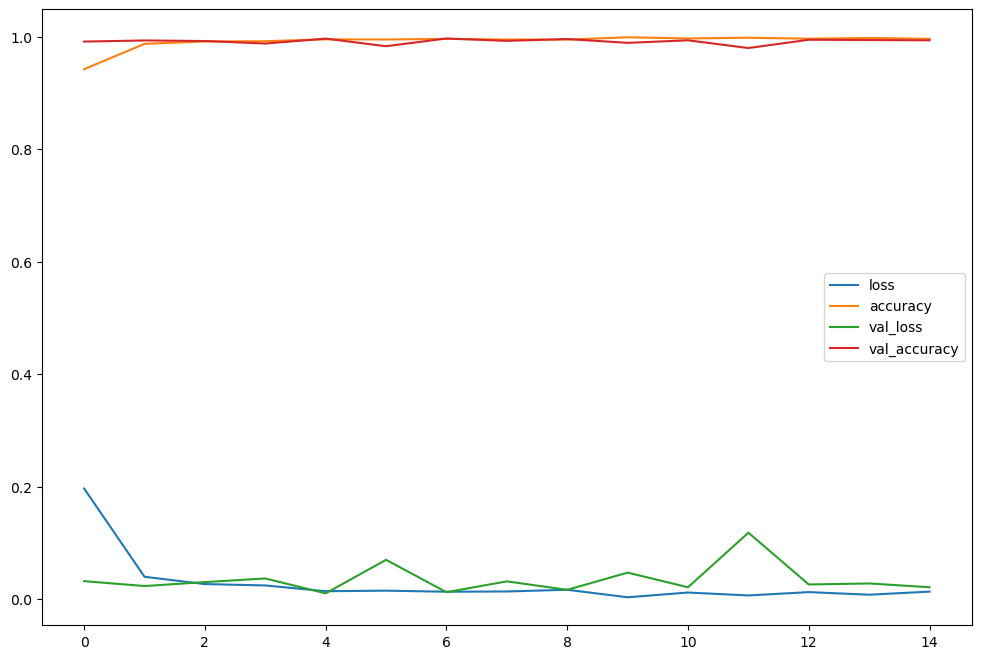

In [36]:
pd.DataFrame(history.history).plot(figsize=(12,8))

In [37]:
model.evaluate(X_test,y_test)

# 188/188 [==============================] - 7s 36ms/step - loss: 0.0239 - accuracy: 0.9935

188/188 [==============================] - 7s 36ms/step - loss: 0.0239 - accuracy: 0.9935


[0.02390148490667343, 0.9934999942779541]

In [38]:
y_test_pred = model.predict(X_test)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)
y_test_true_labels = y_test

188/188 [==============================] - 7s 36ms/step


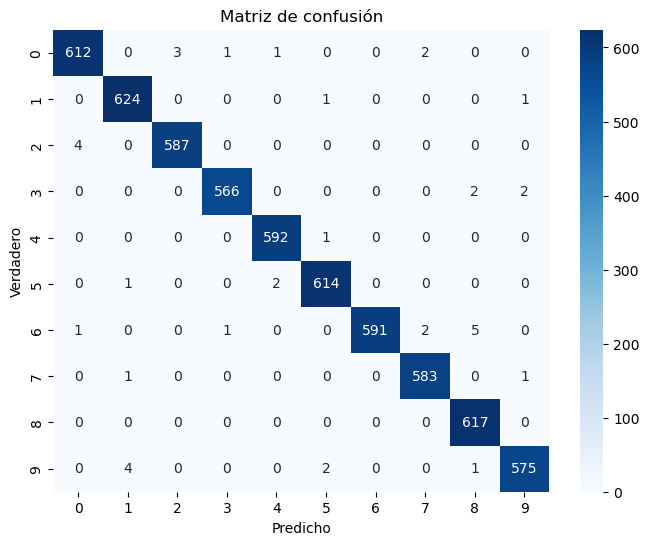

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test_true_labels, y_test_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.ylabel('Verdadero')
plt.xlabel('Predicho')
plt.title('Matriz de confusión')
plt.show()

In [40]:
from sklearn.metrics import classification_report

report = classification_report(y_test_true_labels, y_test_pred_labels, digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.9919    0.9887    0.9903       619
           1     0.9905    0.9968    0.9936       626
           2     0.9949    0.9932    0.9941       591
           3     0.9965    0.9930    0.9947       570
           4     0.9950    0.9983    0.9966       593
           5     0.9935    0.9951    0.9943       617
           6     1.0000    0.9850    0.9924       600
           7     0.9932    0.9966    0.9949       585
           8     0.9872    1.0000    0.9936       617
           9     0.9931    0.9880    0.9905       582

    accuracy                         0.9935      6000
   macro avg     0.9936    0.9935    0.9935      6000
weighted avg     0.9935    0.9935    0.9935      6000

